# Classification

Este bloco de notas tem como objetivo fornecer uma visão geral das métricas de classificação que podem ser usadas para avaliar o desempenho da generalização do modelo preditivo. Podemos lembrar que, em uma configuração de classificação, o vetor `target` é categórico em vez de contínuo.

Carregaremos o conjunto de dados de transfusão de sangue.

In [1]:
from urllib.request import urlretrieve 
# lembre de sempre pegar o arquivo do tipo RAW no github 
url = 'https://raw.githubusercontent.com/INRIA/scikit-learn-mooc/end-of-v1.0-session/datasets/blood_transfusion.csv'
urlretrieve(url, 'C:/Users/Rogerio Lopes/Desktop/Rogerio/Machine_Learning_With_Scikit_Learn/Module7_evaluanting_model_performance/blood_transfusion.csv')

('C:/Users/Rogerio Lopes/Desktop/Rogerio/Machine_Learning_With_Scikit_Learn/Module7_evaluanting_model_performance/blood_transfusion.csv',
 <http.client.HTTPMessage at 0x1f822c27940>)

In [2]:
import pandas as pd

blood_transfusion = pd.read_csv("blood_transfusion.csv")
data = blood_transfusion.drop(columns="Class")
target = blood_transfusion["Class"]

Vamos começar verificando as classes presentes no vetor de destino `target`.

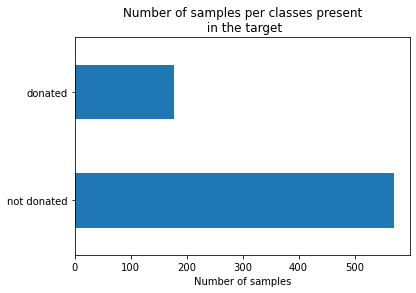

In [3]:
import matplotlib.pyplot as plt

target.value_counts().plot.barh()
plt.xlabel("Number of samples")
_ = plt.title("Number of samples per classes present\n in the target")

Podemos ver que o vetor `target` contém duas classes correspondentes a se um sujeito doou sangue. Usaremos um classificador de regressão logística para prever esse resultado.

Para focar na apresentação das métricas, usaremos apenas uma única divisão em vez de validação cruzada.

In [4]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, shuffle=True, random_state=0, test_size=0.5)

Usaremos um classificador de regressão logística como modelo base. Treinaremos o modelo no conjunto de treinamento e, posteriormente, usaremos o conjunto de teste para calcular as diferentes métricas de classificação.

In [5]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
classifier.fit(data_train, target_train)

LogisticRegression()

### Classifier predictions

Antes de entrarmos em detalhes sobre as métricas, vamos lembrar que tipo de previsões um classificador pode fornecer.

Por isso, vamos criar uma amostra sintética para um novo potencial doador: ele doou sangue duas vezes no passado (1000 cc cada vez). A última vez foi há 6 meses, e a primeira vez foi há 20 meses.

In [6]:
new_donor = [[6, 2, 1000, 20]]

Podemos obter a classe prevista pelo classificador chamando o método `predict`.

In [7]:
classifier.predict(new_donor)

array(['not donated'], dtype=object)

Com essas informações, nosso classificador prevê que esse sujeito sintético tem maior probabilidade de não doar sangue novamente.

No entanto, não podemos verificar se a previsão está correta (não sabemos o verdadeiro valor alvo). Esse é o propósito do conjunto de teste. Primeiro, predizemos se um sujeito doará sangue com a ajuda de um classificador treinado.

In [8]:
target_predicted = classifier.predict(data_test)
target_predicted[:5]

array(['not donated', 'not donated', 'not donated', 'not donated',
       'donated'], dtype=object)

### Accuracy as a baseline

Agora que temos essas previsões, podemos compará-las com as previsões verdadeiras (às vezes chamadas de verdade fundamental) que não usamos até agora.

In [9]:
target_test == target_predicted

258     True
521    False
14     False
31     False
505     True
       ...  
665     True
100    False
422     True
615     True
743     True
Name: Class, Length: 374, dtype: bool

Na comparação acima, um `True` valor significa que o valor predito por nosso classificador é idêntico ao valor real, enquanto um `False` significa que nosso classificador cometeu um erro. Uma maneira de obter uma taxa geral que representa o desempenho de generalização de nosso classificador seria calcular quantas vezes nosso classificador estava certo e dividi-lo pelo número de amostras em nosso conjunto.

In [10]:
import numpy as np

np.mean(target_test == target_predicted)

0.7780748663101604

Essa medida é chamada de precisão. Aqui, nosso classificador é 78% preciso em classificar se um sujeito vai doar sangue. `scikit-learn` fornece uma função que calcula essa métrica no módulo `sklearn.metrics`.

In [11]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(target_test, target_predicted)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.778


`LogisticRegression` também tem um método denominado score(parte da API `scikit-learn` padrão), que calcula a pontuação de precisão.

In [12]:
classifier.score(data_test, target_test)

0.7780748663101604

### Confusion matrix and derived metrics 

A comparação que fizemos acima e a precisão que calculamos não levou em consideração o tipo de erro que nosso classificador estava cometendo. A precisão é um agregado dos erros cometidos pelo classificador. Podemos estar interessados ​​em granularidade mais fina - para saber independentemente qual é o erro para cada um dos dois casos a seguir:

* previmos que uma pessoa doaria sangue, mas ela não deu;
* previmos que uma pessoa não doaria sangue, mas ela deu.

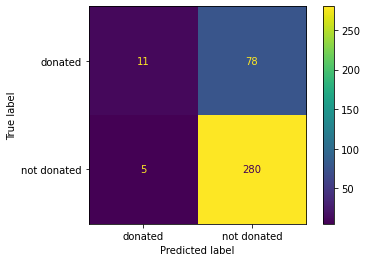

In [13]:
from sklearn.metrics import plot_confusion_matrix

_ = plot_confusion_matrix(classifier, data_test, target_test)

Os números na diagonal estão relacionados a previsões que estavam corretas, enquanto os números fora da diagonal estão relacionados a previsões incorretas (classificações incorretas). Agora conhecemos os quatro tipos de previsões corretas e erradas:

* o canto superior esquerdo são verdadeiros positivos (TP) e correspondem às pessoas que doaram sangue e foram preditas como tal pelo classificador;
* o canto inferior direito são verdadeiros negativos (TN) e correspondem a pessoas que não doaram sangue e foram preditas como tal pelo classificador;
* o canto superior direito são falsos negativos (FN) e correspondem a pessoas que doaram sangue, mas foi previsto que não doaram;
* o canto inferior esquerdo são falsos positivos (PF) e correspondem a pessoas que não deram sangue, mas que se previa que tivessem dado sangue.

Depois de dividir essas informações, podemos calcular métricas para destacar o desempenho de generalização de nosso classificador em uma configuração particular. Por exemplo, podemos estar interessados ​​na fração de pessoas que realmente doou sangue quando o classificador previu ou na fração de pessoas que previu que doou sangue entre o total da população que realmente o fez.

A primeira métrica, conhecida como precisão, é definida como TP / (TP + FP) e representa a probabilidade de a pessoa realmente ter dado sangue quando o classificador previu que sim. Este último, conhecido como recall, é definido como TP / (TP + FN) e avalia o quão bem o classificador é capaz de identificar corretamente as pessoas que doaram sangue. Poderíamos, da mesma forma que a precisão, calcular manualmente esses valores; no entanto, o scikit-learn fornece funções para calcular essas estatísticas.

In [14]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(target_test, target_predicted, pos_label="donated")
recall = recall_score(target_test, target_predicted, pos_label="donated")

print(f"Precision score: {precision:.3f}")
print(f"Recall score: {recall:.3f}")

Precision score: 0.688
Recall score: 0.124


Esses resultados estão de acordo com o que foi visto na matriz de confusão. Olhando para a coluna da esquerda, mais da metade das previsões "doadas" estavam corretas, levando a uma precisão acima de 0,5. No entanto, nosso classificador classificou erroneamente muitas pessoas que doaram sangue como "não doado", levando a um recall muito baixo de cerca de 0,1.

### A questão do desequilíbrio de classe

Nesse estágio, poderíamos nos fazer uma pergunta razoável. Embora a precisão não pareça ruim (ou seja, 77%), a pontuação de recall é relativamente baixa (ou seja, 12%).

Como mencionamos, a precisão e a recuperação se concentram apenas nas amostras que se prevê serem positivas, enquanto a precisão leva ambos em consideração. Além disso, não examinamos a proporção das classes (rótulos). Podemos verificar essa proporção no conjunto de treinamento.

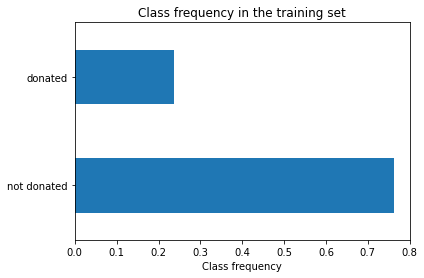

In [15]:
target_train.value_counts(normalize=True).plot.barh()
plt.xlabel("Class frequency")
_ = plt.title("Class frequency in the training set")

Observamos que a classe positiva, `'donated'` compreende apenas 24% das amostras. A boa precisão do nosso classificador está então ligada à sua capacidade de prever corretamente a classe negativa `'not donated'` que pode ou não ser relevante, dependendo da aplicação. Podemos ilustrar o problema usando um classificador fictício como linha de base.

In [16]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(data_train, target_train)
print(f"Accuracy of the dummy classifier: "
      f"{dummy_classifier.score(data_test, target_test):.3f}")

Accuracy of the dummy classifier: 0.762


Com o classificador dummy, que sempre prevê a classe negativa `'notdonated'`, obtemos um escore de acerto de 76%. Portanto, significa que este classificador, sem aprender nada com os dados `data`, é capaz de prever com tanta precisão quanto nosso modelo de regressão logística.

O problema ilustrado acima também é conhecido como problema de desequilíbrio de classes. Quando as classes são desequilibradas, a precisão não deve ser usada. Nesse caso, deve-se usar a precisão e a recuperação conforme apresentado acima ou a pontuação de precisão balanceada em vez da precisão.

In [17]:
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy = balanced_accuracy_score(target_test, target_predicted)
print(f"Balanced accuracy: {balanced_accuracy:.3f}")

Balanced accuracy: 0.553


A precisão balanceada é equivalente à precisão no contexto de classes balanceadas. É definido como a recordação média obtida em cada aula.

### Avaliação e diferentes limites de probabilidade

Todas as estatísticas que apresentamos até agora dependem de `classifier.predict` quais saídas são o rótulo mais provável. Não utilizamos a probabilidade associada a esta previsão, o que dá a confiança do classificador nesta previsão. Por padrão, a previsão de um classificador corresponde a um limite de 0,5 probabilidade em um problema de classificação binária. Podemos verificar rapidamente essa relação com o classificador que treinamos.

In [18]:
target_proba_predicted = pd.DataFrame(classifier.predict_proba(data_test),
                                      columns=classifier.classes_)
target_proba_predicted[:5]

,donated,not donated
0,0.271820,0.728180
1,0.451764,0.548236
2,0.445211,0.554789
3,0.441577,0.558423
4,0.870583,0.129417


In [19]:
target_predicted = classifier.predict(data_test)
target_predicted[:5]

array(['not donated', 'not donated', 'not donated', 'not donated',
       'donated'], dtype=object)

Como as probabilidades somam 1, podemos obter a classe com a maior probabilidade sem usar o limite 0,5.

In [20]:
equivalence_pred_proba = (
    target_proba_predicted.idxmax(axis=1).to_numpy() == target_predicted)
np.all(equivalence_pred_proba)

True

O limite de decisão padrão (0,5) pode não ser o melhor limite que leva ao desempenho de generalização ideal de nosso classificador. Nesse caso, pode-se variar o limite de decisão e, portanto, a previsão subjacente, e calcular as mesmas estatísticas apresentadas anteriormente. Normalmente, a recuperação e a precisão das duas métricas são calculadas e plotadas em um gráfico. Cada métrica traçada em um eixo de gráfico e cada ponto no gráfico corresponde a um limite de decisão específico. Vamos começar calculando a curva de recuperação de precisão.

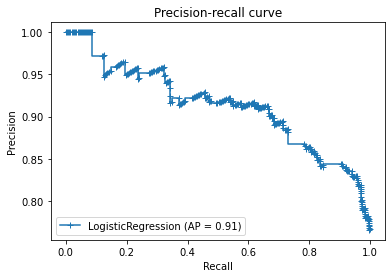

In [26]:
# donated
from sklearn.metrics import plot_precision_recall_curve

disp = plot_precision_recall_curve(
    classifier, data_test, target_test, 
    marker="+"
)
_ = disp.ax_.set_title("Precision-recall curve")

Nesta curva, cada cruz azul corresponde a um nível de probabilidade que usamos como limite de decisão. Podemos ver que, variando este limite de decisão, obtemos diferentes valores de precisão vs. recall.

Um classificador perfeito teria uma precisão de 1 para todos os valores de rechamada. Uma métrica que caracteriza a curva está ligada à área sob a curva (AUC) e é chamada de precisão média (AP). Com um classificador ideal, a precisão média seria 1.

A métrica de precisão e recall concentra-se na classe positiva, no entanto, pode-se estar interessado no meio-termo entre discriminar com precisão a classe positiva e discriminar com precisão as classes negativas. As estatísticas usadas para isso são sensibilidade e especificidade. Sensibilidade é apenas outro nome para recordar. No entanto, a especificidade mede a proporção de amostras classificadas corretamente na classe negativa definida como: TN / (TN + FP). Semelhante à curva de recuperação de precisão, a sensibilidade e a especificidade são geralmente plotadas como uma curva chamada curva de característica de operação do receptor (ROC). Abaixo está essa curva:

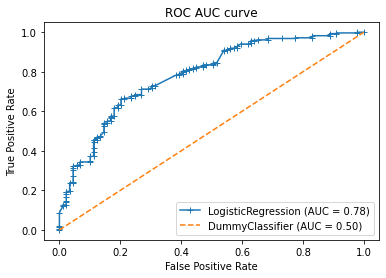

In [28]:
# donated
from sklearn.metrics import plot_roc_curve

disp = plot_roc_curve(
    classifier, data_test, target_test,
    marker="+")
disp = plot_roc_curve(
    dummy_classifier, data_test, target_test,
    color="tab:orange", linestyle="--", ax=disp.ax_)
_ = disp.ax_.set_title("ROC AUC curve")

Essa curva foi construída usando o mesmo princípio da curva de recuperação de precisão: variamos o limite de probabilidade para determinar a previsão "difícil" e computar as métricas. Tal como acontece com a curva de recuperação de precisão, podemos calcular a área sob o ROC (ROC-AUC) para caracterizar o desempenho de generalização de nosso classificador. No entanto, é importante observar que o limite inferior do ROC-AUC é 0,5. Na verdade, mostramos o desempenho de generalização de um classificador dummy (a linha tracejada laranja) para mostrar que mesmo o pior desempenho de generalização obtido estará acima desta linha.

# 📝 Exercício M7.02
Apresentamos diferentes métricas de classificação no caderno anterior. No entanto, não o usamos com uma validação cruzada. Este exercício visa praticar e implementar a validação cruzada.

Vamos reutilizar o conjunto de dados de transfusão de sangue.

In [1]:
import pandas as pd

blood_transfusion = pd.read_csv("blood_transfusion.csv")
data = blood_transfusion.drop(columns="Class")
target = blood_transfusion["Class"]

Primeiro, crie um classificador de árvore de decisão.

In [3]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

Crie um `StratifiedKFold` objeto de validação cruzada. Em seguida, use-o dentro da `cross_val_score` função para avaliar a árvore de decisão. Primeiro, usaremos a precisão como uma função de pontuação. Use explicitamente o `scoring` parâmetro de `cross_val_score` para calcular a precisão (mesmo que seja a pontuação padrão). Verifique sua documentação para saber como fazer isso.

In [4]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

cv = StratifiedKFold(n_splits=10)
scores = cross_val_score(tree, data, target, cv=cv, scoring="accuracy")
print(f"Accuracy score: {scores.mean():.3f} +/- {scores.std():.3f}")

Accuracy score: 0.635 +/- 0.139


Repita o experimento calculando o `balanced_accuracy`.

In [5]:
scores = cross_val_score(tree, data, target, cv=cv,
                         scoring="balanced_accuracy")
print(f"Balanced accuracy score: {scores.mean():.3f} +/- {scores.std():.3f}")

Balanced accuracy score: 0.506 +/- 0.106


Agora vamos adicionar um pouco de complexidade. Gostaríamos de calcular a precisão do nosso modelo. No entanto, ao longo do curso vimos que é necessário mencionar o rótulo positivo que, no nosso caso, consideramos ser a classe `donated`.

Mostraremos que calcular a precisão sem fornecer o rótulo positivo não será compatível com o scikit-learn porque é realmente ambíguo.

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
try:
    scores = cross_val_score(tree, data, target, cv=10, scoring="precision")
except ValueError as exc:
    print(exc)

pos_label=1 is not a valid label: array(['donated', 'not donated'], dtype='<U11')


C:\Users\Rogerio Lopes\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1254: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:


Capturamos a exceção com um padrão try / except para poder imprimi-la.

Recebemos uma exceção porque o marcador padrão tem seu rótulo positivo definido como um (`pos_label=1`), o que não é o nosso caso (nosso rótulo positivo é "doado"). Nesse caso, precisamos criar um marcador usando a função de pontuação e a função auxiliar `make_scorer`.

Então, importe `sklearn.metrics.make_scorer` e `sklearn.metrics.precision_score`. Verifique suas documentações para obter mais informações. Finalmente, crie um marcador chamando `make_scorer` usando a função score `precision_scoree` passe o parâmetro extra `pos_label="donated"`.

In [7]:
from sklearn.metrics import make_scorer, precision_score

precision = make_scorer(precision_score, pos_label="donated")

Agora, em vez de fornecer a string `"precision"` para o `scoring` parâmetro na `cross_val_score` chamada, passe o marcador que você criou acima.

In [8]:
scores = cross_val_score(tree, data, target, cv=cv, scoring=precision)
print(f"Precision score: {scores.mean():.3f} +/- {scores.std():.3f}")

Precision score: 0.245 +/- 0.167


`cross_val_score` irá computar apenas uma única pontuação fornecida ao `scoring` parâmetro. A função `cross_validate` permite o cálculo de múltiplas pontuações, passando uma lista de string ou marcador para o parâmetro `scoring`, o que pode ser útil.

Importe `sklearn.model_selection.cross_validate` e calcule a precisão e precisão equilibrada por meio de validação cruzada. Plote a pontuação de validação cruzada para ambas as métricas usando um gráfico de caixa.

In [9]:
from sklearn.model_selection import cross_validate
scoring = ["accuracy", "balanced_accuracy"]

scores = cross_validate(tree, data, target, cv=cv, scoring=scoring)
scores

{'fit_time': array([0.00394177, 0.00347281, 0.00398874, 0.00487208, 0.00299168,
        0.00199461, 0.00199437, 0.0036571 , 0.00300145, 0.00295639]),
 'score_time': array([0.00249672, 0.00207639, 0.00398874, 0.0039885 , 0.00225854,
        0.00199533, 0.0023427 , 0.00199461, 0.00199652, 0.00199485]),
 'test_accuracy': array([0.26666667, 0.50666667, 0.78666667, 0.54666667, 0.58666667,
        0.64      , 0.69333333, 0.77333333, 0.64864865, 0.74324324]),
 'test_balanced_accuracy': array([0.38450292, 0.46637427, 0.66959064, 0.37865497, 0.40497076,
        0.42105263, 0.55116959, 0.73684211, 0.4623323 , 0.50309598])}

In [10]:
import pandas as pd

color = {"whiskers": "black", "medians": "black", "caps": "black"}

metrics = pd.DataFrame(
    [scores["test_accuracy"], scores["test_balanced_accuracy"]],
    index=["Accuracy", "Balanced accuracy"]
).T

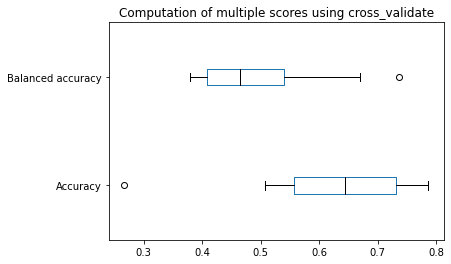

In [11]:
import matplotlib.pyplot as plt

metrics.plot.box(vert=False, color=color)
_ = plt.title("Computation of multiple scores using cross_validate")